In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import math
from PIL import Image
from sklearn.model_selection import cross_validate, train_test_split
from keras.utils import np_utils
from keras.applications.vgg16 import VGG16


from skimage.io import imread, imsave

import tensorflow as tf
import keras.models as models
from keras.models import Model
from keras.layers import Input, concatenate
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adamax, Adam, SGD

Using TensorFlow backend.


In [3]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))

In [4]:
def categorical_crossentropy_with_logits(y_true, y_pred):
    return K.categorical_crossentropy(y_true, y_pred, from_logits=False)

In [5]:
from sklearn.utils import class_weight
from keras.regularizers import l2

class FCNModel:
    
    def __init__(self, **args):
        pass
    def initialize_model(self, dropout=False, weights=None):
        K.clear_session()
        inputs = Input((None,None,3))
        vgg16 = VGG16(include_top=False, weights=weights, input_tensor=inputs, input_shape=(None, None, 3))
        
        input_vgg16 = vgg16.get_layer('block3_pool').output
        if dropout:
            input_vgg16 = Dropout(0.5)(input_vgg16)
        output = UpSampling2D(2)(input_vgg16)
        output = BatchNormalization()(Conv2D(256, 3, padding='same', activation='relu')(output))
        output = BatchNormalization()(Conv2D(256, 3, padding='same', activation='relu')(output))
        output = BatchNormalization()(Conv2D(256, 3, padding='same', activation='relu')(output))
        if dropout:
             output = Dropout(0.25)(output)
        output = UpSampling2D(2)(output)
        output = BatchNormalization()(Conv2D(128, 3, padding='same', activation='relu')(output))
        output = BatchNormalization()(Conv2D(128, 3, padding='same', activation='relu')(output))
        if dropout:
             output = Dropout(0.25)(output)
        output = UpSampling2D(2)(output)
        output = BatchNormalization()(Conv2D(64, 3, padding='same', activation='relu')(output))
        output = BatchNormalization()(Conv2D(64, 3, padding='same', activation='relu')(output))
        if dropout:
             output = Dropout(0.25)(output)
        output = Conv2D(2, 1, padding='same', activation='softmax')(output)

        self.model = Model(inputs, output)

    
    def fit(self, imgs, gt_imgs, augment=False, dropout = False, weights=None,
            num_batches=2, steps_per_epoch=64, epochs=5, validation_steps=32, verbose=1, seed=42):
        self.initialize_model(dropout)

        def one_hot_encode(gt):
            gt = np.round(gt).astype(int)
            encoded = np.zeros((gt.shape[0], gt.shape[1], 2))
            for i in range(gt.shape[0]):
                for j in range(gt.shape[1]):
                    encoded[i][j][gt[i][j]] = 1
            return encoded
        
        def generate_train(batch_size, imgs, gt_imgs, augment=False, seed=1):
            np.random.seed(seed)
            while 1:
                batch_x = []
                batch_y = []
                for i in range(batch_size):
                    idx = np.random.choice(imgs.shape[0])
                    img = imgs[idx]
                    gt = one_hot_encode(gt_imgs[idx])
                    if augment:
                        if np.random.choice(2):
                            img_crop = np.flipud(img)
                            gt_crop = np.flipud(gt)
                        if np.random.choice(2):
                            img_crop = np.fliplr(img)
                            gt_crop = np.fliplr(gt)
                        rot = np.random.choice(4)
                        img_crop = np.rot90(img, rot)
                        gt_crop = np.rot90(gt, rot)
                    batch_x.append(img)
                    batch_y.append(gt)
                yield(np.array(batch_x), np.array(batch_y))
        
        train_generator = generate_train(num_batches, imgs, gt_imgs, augment=augment, seed=seed)
        
        def softmax_categorical_crossentropy(y_true, y_pred):
            return K.categorical_crossentropy(y_true, y_pred, from_logits=True)

        self.model.compile(loss=softmax_categorical_crossentropy, optimizer='adam', metrics=['accuracy', f1])
        self.model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=verbose)
        
    def predict(self, imgs, batch_size=2):
        predictions = self.model.predict(imgs, batch_size)
        return np.argmax(crop_and_one_hot(np.expand_dims(np.argmax(predictions, axis=3), -1)), axis=1)
    
    def get_params(self, deep=True):
        return {'x': None}
    
    def set_params(self, **params):
        pass

In [40]:
from cross_validation import k_fold_model
from helpers import *
imgs, gt_imgs = load_training('training')
fcnModel = FCNModel()

fit_params = {'num_batches' : 1, 'steps_per_epoch': 1, 'epochs' : 1}

cv_score = k_fold_model(fcnModel, imgs, gt_imgs, fit_params=fit_params)
print("The logistic model scored %.3f ± %.3f as f1-score"%(cv_score['test_f1'].mean(), cv_score['test_f1'].std()))
print("The logistic model scored %.3f ± %.3f as accuracy"%(cv_score['test_acc'].mean(), cv_score['test_acc'].std()))

Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 0.7578 - acc: 0.4693 - f1: 0.4693
(15625,)
(15625,)
(46875,)
(46875,)
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 0.7311 - acc: 0.5129 - f1: 0.5129
(15625,)
(15625,)


/home/raph/.conda/envs/keras/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(46875,)
(46875,)
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 0.7311 - acc: 0.5129 - f1: 0.5129
(15625,)
(15625,)
(46875,)
(46875,)
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 0.7539 - acc: 0.4771 - f1: 0.4771
(15625,)
(15625,)
(46875,)
(46875,)
The logistic model scored 0.000 ± 0.001 as f1-score
The logistic model scored 0.741 ± 0.024 as accuracy


In [ ]:
from cross_validation import k_fold_model
from helpers import *
imgs, gt_imgs = load_training('training')
fcnModel = FCNModel()

for weights in (None, 'imagenet'):
    for augment in (False, True):
        for dropout in (False, True):
            fit_params = {'augment': augment, 'dropout': dropout, 'weights': weights,
                          'num_batches' : 2, 'steps_per_epoch': 64, 'epochs' : 10, 'verbose': 0}
            scoring_params = {'batch_size': 2}

            cv_score = k_fold_model(fcnModel, imgs, gt_imgs, fit_params=fit_params, scoring_params=scoring_params, n_fold=4)
            print("Cnn model with window %d, augment %r, dropout %r"%(window, augment, dropout))
            print("Accuracy: %.3f ± %.3f"%(cv_score['test_acc'].mean(), cv_score['test_acc'].std()))
            print("F1 score %.3f ± %.3f"%(cv_score['test_f1'].mean(), cv_score['test_f1'].std()))

In [10]:
from cross_validation import k_fold_model
from helpers import *
imgs, gt_imgs = load_training('training')
fcnModel = FCNModel()

for weights in ['imagenet']:
    for augment in [True]:
        for dropout in [True]:
            fit_params = {'augment': augment, 'dropout': dropout, 'weights': weights,
                          'num_batches' : 1, 'steps_per_epoch': 64, 'epochs' : 1, 'verbose': 1}
            scoring_params = {'batch_size': 1}

            cv_score = k_fold_model(fcnModel, imgs, gt_imgs, fit_params=fit_params, scoring_params=scoring_params, n_fold=4)
            print("Cnn model with window %s, augment %r, dropout %r"%(weights, augment, dropout))
            print("Accuracy: %.3f ± %.3f"%(cv_score['test_acc'].mean(), cv_score['test_acc'].std()))
            print("F1 score %.3f ± %.3f"%(cv_score['test_f1'].mean(), cv_score['test_f1'].std()))

Epoch 1/1
64/64 [==============================] - 45s 710ms/step - loss: 0.5948 - acc: 0.7181 - f1: 0.7181
Epoch 1/1
64/64 [==============================] - 46s 712ms/step - loss: 0.6346 - acc: 0.6787 - f1: 0.6787


/home/raph/.conda/envs/keras/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch 1/1
64/64 [==============================] - 46s 722ms/step - loss: 0.5711 - acc: 0.7424 - f1: 0.7424
Epoch 1/1
64/64 [==============================] - 46s 712ms/step - loss: 0.5730 - acc: 0.7455 - f1: 0.7455


TypeError: %d format: a number is required, not str

In [6]:
K.clear_session()

In [8]:
inputs = Input((None,None,3))
vgg16 = VGG16(include_top=False, weights=None, input_tensor=inputs, input_shape=(None, None, 3))

In [9]:
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [10]:
x = vgg16.get_layer('block3_pool').output
# x = Dropout(0.5)(x)
x = UpSampling2D(2)(x)
x = BatchNormalization()(Conv2D(256, 3, padding='same', activation='relu')(x))
x = BatchNormalization()(Conv2D(256, 3, padding='same', activation='relu')(x))
x = BatchNormalization()(Conv2D(256, 3, padding='same', activation='relu')(x))
# x = Dropout(0.5)(x)
x = UpSampling2D(2)(x)
x = BatchNormalization()(Conv2D(128, 3, padding='same', activation='relu')(x))
x = BatchNormalization()(Conv2D(128, 3, padding='same', activation='relu')(x))
# x = Dropout(0.5)(x)
x = UpSampling2D(2)(x)
x = BatchNormalization()(Conv2D(64, 3, padding='same', activation='relu')(x))
x = BatchNormalization()(Conv2D(64, 3, padding='same', activation='relu')(x))
# x = Dropout(0.5)(x)
x = Conv2D(2, 1, padding='same', activation='softmax')(x)

model = Model(inputs, x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [ ]:
model.compile(optimizer='adam', loss=categorical_crossentropy_with_logits, metrics=['accuracy', f1])

model.fit_generator(generate, steps_per_epoch=64, epochs=20, validation_data=(test_x, test_y))

Epoch 1/20
64/64 [==============================] - 66s 1s/step - loss: 0.6269 - acc: 0.6840 - f1: 0.6840 - val_loss: 2.8305 - val_acc: 0.7895 - val_f1: 0.7895
Epoch 2/20
64/64 [==============================] - 60s 944ms/step - loss: 0.4757 - acc: 0.8061 - f1: 0.8061 - val_loss: 2.1834 - val_acc: 0.7895 - val_f1: 0.7895
Epoch 3/20
64/64 [==============================] - 61s 947ms/step - loss: 0.4670 - acc: 0.7930 - f1: 0.7930 - val_loss: 1.0270 - val_acc: 0.7895 - val_f1: 0.7895
Epoch 4/20
64/64 [==============================] - 61s 949ms/step - loss: 0.4450 - acc: 0.8004 - f1: 0.8004 - val_loss: 1.6425 - val_acc: 0.7895 - val_f1: 0.7895
Epoch 5/20
64/64 [==============================] - 61s 949ms/step - loss: 0.4289 - acc: 0.8073 - f1: 0.8073 - val_loss: 0.8850 - val_acc: 0.7895 - val_f1: 0.7895
Epoch 6/20
64/64 [==============================] - 61s 949ms/step - loss: 0.3965 - acc: 0.8128 - f1: 0.8128 - val_loss: 1.0141 - val_acc: 0.7895 - val_f1: 0.7895
Epoch 7/20
37/64 [=======

In [182]:
res = model.predict(test_x, batch_size=2)

In [187]:
np.argmax(res, axis=3).shape

(80, 304, 304)

In [198]:
from helpers import *

In [218]:
f1_score(np.argmax(crop_and_one_hot(np.argmax(test_y, axis=3).reshape(80, 304, 304,1)), axis=1), np.argmax(crop_and_one_hot(np.argmax(res, axis=3).reshape(80, 304, 304,1)), axis=1))

0.85811668782998052

In [192]:
res2.shape

(320, 304, 304, 2)

In [171]:
np.array(train_x).shape

(320, 304, 304, 3)

In [183]:
f1_score(np.argmax(crop_and_one_hot(np.argmax(test_y, axis=3).reshape(80, 304, 304,1)), axis=1), np.argmax(crop_and_one_hot(res), axis=1))

0.42992280091334129

In [193]:
f1_score(np.argmax(crop_and_one_hot(np.argmax(train_y, axis=3).reshape(320, 304, 304,1)), axis=1), np.argmax(crop_and_one_hot(np.argmax(res2, axis=3).reshape(320, 304, 304,1)), axis=1))

0.89662921348314606

In [145]:
from sklearn.metrics import f1_score
f1_score(np.argmax(test_y, axis=3).flatten(), np.argmax(res, axis=3).flatten())

0.019922333727256797

In [3]:
from keras.applications.vgg16 import VGG16
shape = 304
inputs = Input((shape,shape,3))
vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs, input_shape=(shape, shape, 3))

In [4]:
x = vgg16.get_layer('block3_pool').output
x = Dropout(0.5)(x)
x = UpSampling2D(2)(x)
x = BatchNormalization()(Conv2D(256, 3, padding='same', activation='relu')(x))
x = BatchNormalization()(Conv2D(256, 3, padding='same', activation='relu')(x))
x = BatchNormalization()(Conv2D(256, 3, padding='same', activation='relu')(x))
x = Dropout(0.5)(x)
x = UpSampling2D(2)(x)
x = BatchNormalization()(Conv2D(128, 3, padding='same', activation='relu')(x))
x = BatchNormalization()(Conv2D(128, 3, padding='same', activation='relu')(x))
x = Dropout(0.5)(x)
x = UpSampling2D(2)(x)
x = BatchNormalization()(Conv2D(64, 3, padding='same', activation='relu')(x))
x = BatchNormalization()(Conv2D(64, 3, padding='same', activation='relu')(x))
x = Dropout(0.5)(x)
x = Conv2D(2, 1, padding='same', activation='softmax')(x)

model = Model(inputs, x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 304, 304, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 304, 304, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 304, 304, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 152, 152, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 152, 152, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 152, 152, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 76, 76, 128)       0         
__________

In [8]:
def one_hot_encode(gt):
    gt = np.round(gt).astype(int)
    encoded = np.zeros((gt.shape[0], gt.shape[1], 2))
    for i in range(gt.shape[0]):
        for j in range(gt.shape[1]):
            encoded[i][j][gt[i][j]] = 1
    return encoded

def one_hot_encode_gts(gts):
    encoded = []
    for gt in gts:
        encoded.append(one_hot_encode(gt))
    return np.array(encoded)

In [9]:
from helpers import *
imgs, gt_imgs = load_training('training')
gt_imgs = one_hot_encode_gts(gt_imgs)
X_train, X_test, y_train, y_test = train_test_split(imgs, gt_imgs, test_size=0.2, random_state=1)

In [12]:
window = 304

def crop_img(img, window):
    window_times = math.ceil(img.shape[0] / window)
    patches = []
    img_size = img.shape[0]
    half_size = img_size//2
    half_window = window//2
    for i in range(window_times):
        for j in range(window_times):
            patches.append(img[half_size*i-half_window*i:half_size*i+half_window*(2-i), half_size*j-half_window*j:half_size*j+half_window*(2-j)])
    return patches
    


test_x = []
test_y = []
for i in range(X_test.shape[0]):
    test_x += crop_img(X_test[i], window)
    test_y += crop_img(y_test[i], window)
test_x = np.array(test_x)
test_y = np.array(test_y)

In [13]:
test_y.shape

(80, 304, 304, 2)

In [14]:
import numpy.random as random

random.seed(1)
window = 304
batch_size = 2
augment = True
def generate(batch_size, augment=False, seed=1):
    random.seed(seed)
    while 1:
        batch_x = []
        batch_y = []
        for i in range(batch_size):
            idx = random.choice(X_train.shape[0])
            img = X_train[idx]
            gt = y_train[idx]
            if augment:
                if random.choice(2):
                    img_crop = np.flipud(img)
                    gt_crop = np.flipud(gt)
                if random.choice(2):
                    img_crop = np.fliplr(img)
                    gt_crop = np.fliplr(gt)
                rot = np.random.choice(4)
                img_crop = np.rot90(img, rot)
                gt_crop = np.rot90(gt, rot)
            batch_x.append(img)
            batch_y.append(gt)
        yield(np.array(batch_x), np.array(batch_y))
generate = generate(batch_size, augment)
def generate_test(n):
    while 1:
        idxs = random.randint(0, test_x.shape[0], n)
        yield(test_x[idxs], test_y[idxs])
generate_test = generate_test(batch_size)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
mc = ModelCheckpoint('vgg_fcn2.h5', monitor='val_loss', verbose=1, save_best_only=True)
model.fit_generator(generate, steps_per_epoch=64, epochs=10, validation_data=(test_x, test_y), callbacks=[mc])

Epoch 1/10
64/64 [==============================] - 68s 1s/step - loss: 0.7372 - acc: 0.6698 - f1: 0.6698 - val_loss: 5.7420 - val_acc: 0.2990 - val_f1: 0.2990
Epoch 2/10
64/64 [==============================] - 62s 968ms/step - loss: 0.4638 - acc: 0.8041 - f1: 0.8041 - val_loss: 1.9148 - val_acc: 0.7828 - val_f1: 0.7828
Epoch 3/10
64/64 [==============================] - 62s 974ms/step - loss: 0.4185 - acc: 0.8162 - f1: 0.8162 - val_loss: 1.0372 - val_acc: 0.5966 - val_f1: 0.5966
Epoch 4/10
64/64 [==============================] - 62s 976ms/step - loss: 0.4114 - acc: 0.8160 - f1: 0.8160 - val_loss: 0.4534 - val_acc: 0.7832 - val_f1: 0.7832
Epoch 5/10
63/64 [============================>.] - ETA: 0s - loss: 0.4016 - acc: 0.8185 - f1: 0.8185

In [175]:
model = models.load_model('vgg_fcn2.h5', custom_objects={'f1': f1})

In [58]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
mc = ModelCheckpoint('vgg_fcn2.h5', monitor='val_loss', verbose=1, save_best_only=True)
model.fit_generator(generate, steps_per_epoch=64, epochs=5, validation_data=(test_x, test_y), callbacks=[mc])

Epoch 1/5
64/64 [==============================] - 63s 989ms/step - loss: 0.1127 - acc: 0.9549 - f1: 0.9549 - val_loss: 0.1895 - val_acc: 0.9283 - val_f1: 0.9283
Epoch 2/5
64/64 [==============================] - 62s 970ms/step - loss: 0.1129 - acc: 0.9552 - f1: 0.9552 - val_loss: 0.1827 - val_acc: 0.9311 - val_f1: 0.9311
Epoch 3/5
64/64 [==============================] - 62s 973ms/step - loss: 0.1213 - acc: 0.9527 - f1: 0.9527 - val_loss: 0.1943 - val_acc: 0.9298 - val_f1: 0.9298
Epoch 4/5
64/64 [==============================] - 62s 975ms/step - loss: 0.1209 - acc: 0.9521 - f1: 0.9521 - val_loss: 0.1980 - val_acc: 0.9311 - val_f1: 0.9311
Epoch 5/5
64/64 [==============================] - 62s 976ms/step - loss: 0.1694 - acc: 0.9324 - f1: 0.9324 - val_loss: 0.2574 - val_acc: 0.9100 - val_f1: 0.9100


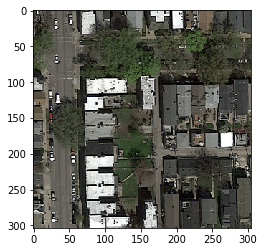

In [59]:
plt.imshow(test_x[1])

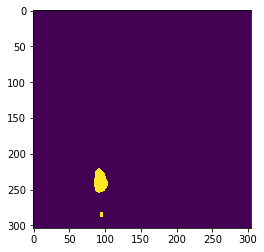

In [98]:
plt.imshow(np.argmax(model.predict(test_x[:4])[1], axis=2))

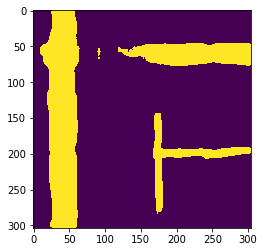

In [181]:
plt.imshow(np.argmax(model.predict(test_x[:4])[1], axis=2))

In [64]:
foreground_threshold = 0.25

# assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0

def mask_to_submission_strings(img_number, img):
    """Reads a single image and outputs the strings that should go into the submission file"""
    patch_size = 16
    for j in range(0, img.shape[1], patch_size):
        for i in range(0, img.shape[0], patch_size):
            patch = img[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


with open('submission_test.csv', 'w') as f:
    f.write('id,prediction\n')
    for i in range(1, 51):
        print("Predicting %d"%i)
        im = mpimg.imread('/home/raph/ML_project2/test_set_images/test_%d/test_%d.png'%(i,i))
        crop = [im[i*304:(i+1)*304,j*304:(j+1)*304].tolist() for i in range(2) for j in range(2)]
        crop = model.predict(np.array(crop))
        crop = np.vstack([np.hstack(crop[i*2:(i+1)*2]) for i in range(2)])
        res = np.argmax(crop, axis=2)
        f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(i, res))

Predicting 1
Predicting 2
Predicting 3
Predicting 4
Predicting 5
Predicting 6
Predicting 7
Predicting 8
Predicting 9
Predicting 10
Predicting 11
Predicting 12
Predicting 13
Predicting 14
Predicting 15
Predicting 16
Predicting 17
Predicting 18
Predicting 19
Predicting 20
Predicting 21
Predicting 22
Predicting 23
Predicting 24
Predicting 25
Predicting 26
Predicting 27
Predicting 28
Predicting 29
Predicting 30
Predicting 31
Predicting 32
Predicting 33
Predicting 34
Predicting 35
Predicting 36
Predicting 37
Predicting 38
Predicting 39
Predicting 40
Predicting 41
Predicting 42
Predicting 43
Predicting 44
Predicting 45
Predicting 46
Predicting 47
Predicting 48
Predicting 49
Predicting 50


In [114]:
b = np.array([[[60, 34],
        [41, 54]],

       [[91, 84],
        [61, 87]]])
a = np.array([[0, 1],[1,0]])
m, n = a.shape
I, J = np.ogrid[:m, :n]
b[I, J, a]

array([[60, 54],
       [84, 61]])

In [118]:
im = mpimg.imread('/home/raph/ML_project2/test_set_images/test_%d/test_%d.png'%(1,1))
crop = [im[i*304:(i+1)*304,j*304:(j+1)*304].tolist() for i in range(2) for j in range(2)]
crop = model.predict(np.array(crop))
crop = np.vstack([np.hstack(crop[i*2:(i+1)*2]) for i in range(2)])
idxs = np.argmax(crop, axis=2)
m, n = idxs.shape
I, J = np.ogrid[:m, :n]
crop[I, J, idxs]

(608, 608)

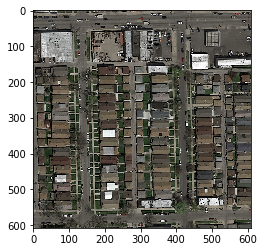

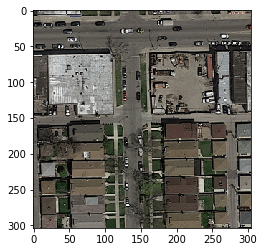

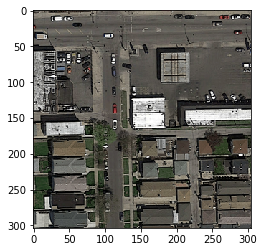

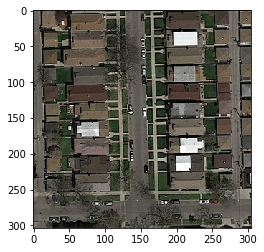

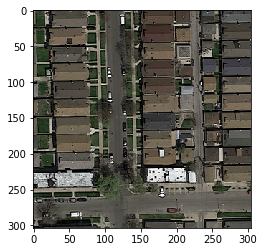

In [62]:
img = load_image('test/test_1/test_1.png')
img_crop = crop_img(img, window)
plt.figure(0)
plt.imshow(img)
for i in range(len(img_crop)):
    plt.figure(i+1)
    plt.imshow(img_crop[i])

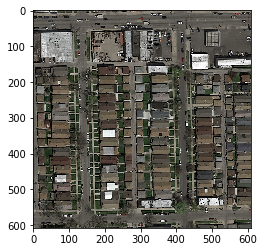

In [70]:
top = np.hstack(np.array(crop_img(img, window))[:2])
bottom = np.hstack(np.array(crop_img(img, window))[2:4])
plt.imshow(np.vstack((top, bottom)))

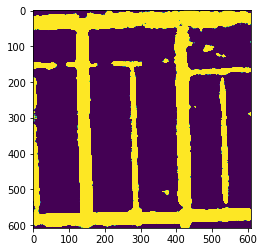

In [78]:
plt.imshow(load_image('predict/predict_1.png'))

In [79]:
load_image('predict/predict_1.png')

array([[ 1593,    78,    50, ...,    66,   216,  2552],
       [   28,     1,     1, ...,    35,    64,   205],
       [   33,     1,     2, ...,     3,     3,    94],
       ..., 
       [  889,    42,    18, ...,     2,     1,    19],
       [ 1471,    58,    18, ...,     1,     1,    70],
       [17993,  2396,   389, ...,    12,    38,  1179]], dtype=uint16)

In [87]:
import os
import numpy as np
import matplotlib.image as mpimg
import re


foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch




def mask_to_submission_strings(image_filename):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", image_filename).group(0))
    im = mpimg.imread(image_filename)

    print(im)
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            print("{:03d}_{}_{},{}".format(img_number, j, i, label))
mask_to_submission_strings('predict/predict_1.png')

[[  2.43076216e-02   1.19020371e-03   7.62951095e-04 ...,   1.00709544e-03
    3.29594873e-03   3.89410257e-02]
 [  4.27252613e-04   1.52590219e-05   1.52590219e-05 ...,   5.34065766e-04
    9.76577401e-04   3.12809949e-03]
 [  5.03547722e-04   1.52590219e-05   3.05180438e-05 ...,   4.57770657e-05
    4.57770657e-05   1.43434806e-03]
 ..., 
 [  1.35652702e-02   6.40878920e-04   2.74662394e-04 ...,   3.05180438e-05
    1.52590219e-05   2.89921416e-04]
 [  2.24460214e-02   8.85023270e-04   2.74662394e-04 ...,   1.52590219e-05
    1.52590219e-05   1.06813153e-03]
 [  2.74555594e-01   3.65606174e-02   5.93575975e-03 ...,   1.83108263e-04
    5.79842832e-04   1.79903861e-02]]
0.0296082
001_0_0,0
0.959307
001_0_16,1
1.0
001_0_32,1
0.421145
001_0_48,1
5.70425e-05
001_0_64,0
0.000108124
001_0_80,0
0.00014353
001_0_96,0
0.000180128
001_0_112,0
0.000158849
001_0_128,0
0.92602
001_0_144,1
0.247732
001_0_160,0
0.106769
001_0_176,0
0.597727
001_0_192,1
0.530729
001_0_208,1
0.571392
001_0_224,1
0.63

1.0
001_496_32,1
0.183993
001_496_48,0
8.36266e-05
001_496_64,0
8.82162e-05
001_496_80,0
0.334202
001_496_96,1
0.0339517
001_496_112,0
6.68178e-05
001_496_128,0
4.4585e-05
001_496_144,0
0.791461
001_496_160,1
0.154449
001_496_176,0
0.000112356
001_496_192,0
9.6859e-05
001_496_208,0
6.65198e-05
001_496_224,0
0.000131013
001_496_240,0
0.000107946
001_496_256,0
3.95781e-05
001_496_272,0
0.000176134
001_496_288,0
0.00011492
001_496_304,0
0.000183645
001_496_320,0
9.87068e-05
001_496_336,0
0.000114025
001_496_352,0
9.91836e-05
001_496_368,0
8.47591e-05
001_496_384,0
7.33148e-05
001_496_400,0
7.02153e-05
001_496_416,0
7.94542e-05
001_496_432,0
0.000108303
001_496_448,0
0.000130596
001_496_464,0
0.000195387
001_496_480,0
9.4296e-05
001_496_496,0
0.000153425
001_496_512,0
8.76202e-05
001_496_528,0
0.349022
001_496_544,1
1.0
001_496_560,1
0.905367
001_496_576,1
0.000127675
001_496_592,0
0.661324
001_512_0,1
1.0
001_512_16,1
0.83316
001_512_32,1
0.00958022
001_512_48,0
8.50571e-05
001_512_64,0
9